# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style


In [2]:
from pythoneeg import constants, core, visualization

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_str_to_genotype', 'parse_str_to_animal', 'parse_str_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer', 'log_transform']


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/core.py:220: UserWarning: LongRecording will be truncated to the first 3 files
  warnings.warn(f"LongRecording will be truncated to the first {self.n_truncate} files")


In [5]:
Path('./test-wars/A5').resolve()

PosixPath('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars/A5')

In [6]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [7]:
%%script true

cluster = LocalCluster()
display(cluster)

# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5', 'A10']
# animal_ids = []
# animal_ids = ['A5']
# animal_ids = ['A10']
animal_ids = ["F22"]
# animal_ids = ['G25']
base_folder = Path("./test-data").resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec()  # parallelization breaks if not enough memory

    ao.compute_bad_channels()

    with Client(cluster) as client:
        # client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        # ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(["all"], multiprocess_mode="serial")
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')



2025-07-08 20:38:00,217 - DEBUG - Using selector: EpollSelector


In [8]:
# df = pd.read_pickle('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-6/062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 CF2/cf2-fwt.pkl')
# display(df)

In [9]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/A10').resolve())
# war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-2/061022_group 9 M1, M2, M3 group9_M1_Cage1').resolve())
# war.result = war.result.head(2)
res1 = war.get_result(['all'], allow_missing=True)
# war.aggregate_time_windows()
war.add_unique_hash()
war.filter_all()
res2 = war.get_result(['all'], allow_missing=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
#                       'display.max_colwidth', 1000, 'display.width', None):
# display(res1)
# display(res2)

2025-07-08 20:38:00,299 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,301 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,301 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,302 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,302 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,303 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,303 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,303 - WARNING - Intan

2025-07-08 20:38:00,370 - INFO - Filtering psd
2025-07-08 20:38:00,371 - INFO - set([x[0].shape for x in result[feat].tolist()]) = [(501,)]
2025-07-08 20:38:00,372 - INFO - set([x[1].shape for x in result[feat].tolist()]) = [(501, 10)]
2025-07-08 20:38:00,374 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,374 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,375 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,375 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,376 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-07-08 20:38:00,376 - WARNING - Intan Input (1)/PortC C-016 does not match 

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/results.py:477: UserWarning: Dropping column 'index'
  warnings.warn("Dropping column 'index'")


In [10]:
print(war.bad_channels_dict)
# war.get_filter_reject_channels_by_recording_session()
# war.filter_all()

{}


2025-07-08 20:38:00,475 - WARNING - zpcorr not calculated, skipping


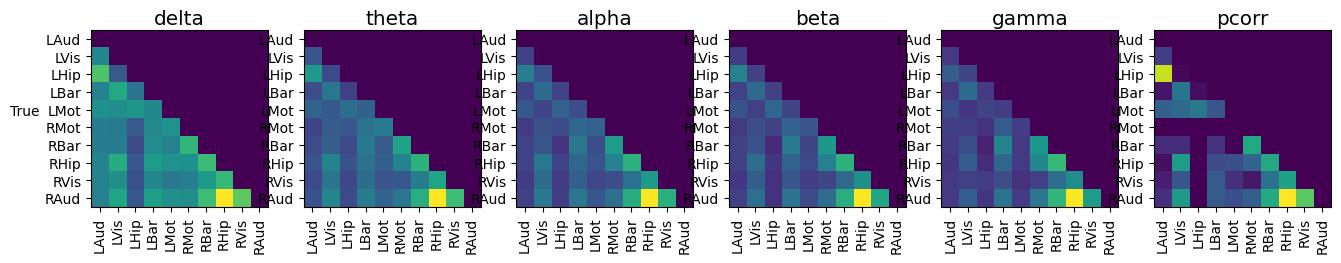

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:294: UserWarning: Feature zpcorr not found in dataframe
  warnings.warn(f"Feature {feature} not found in dataframe")


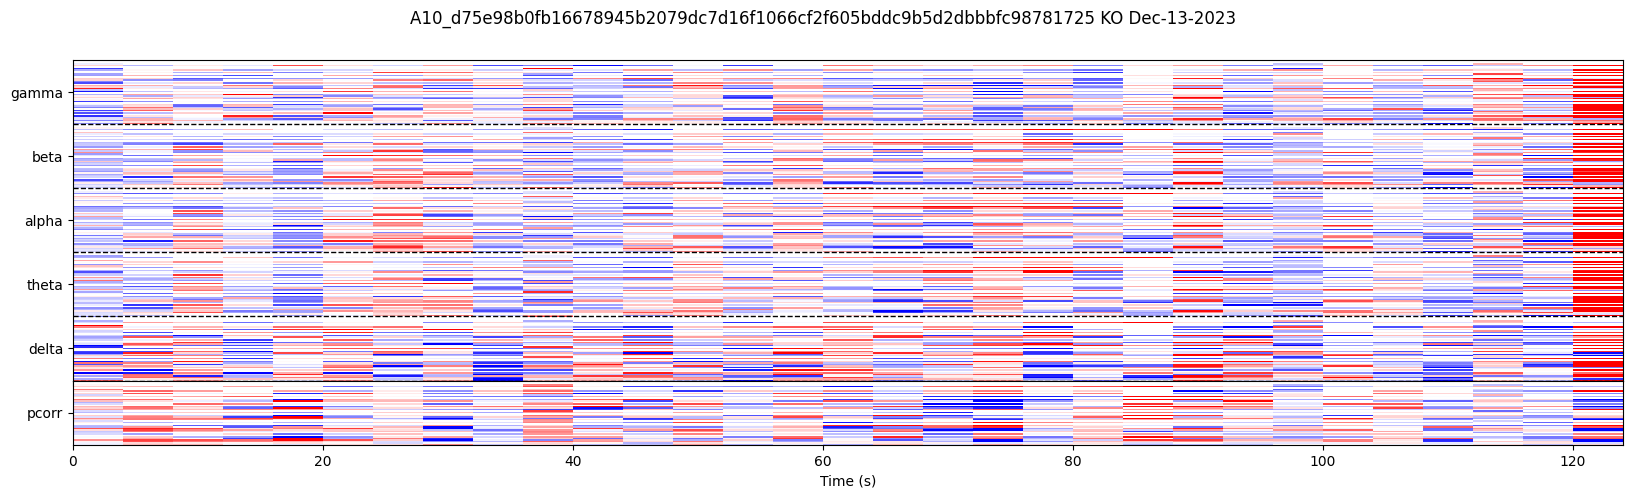

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:417: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10 ** (b + m * np.log10(freqs)), c=f"C{j}", alpha=0.75)


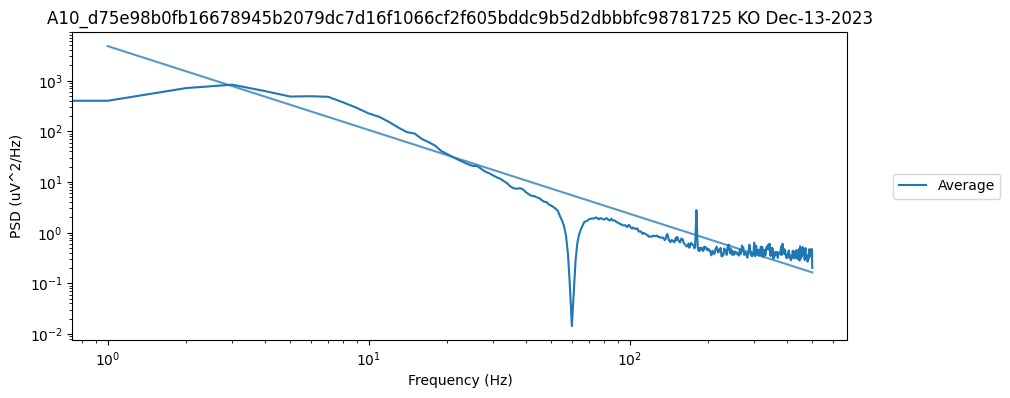

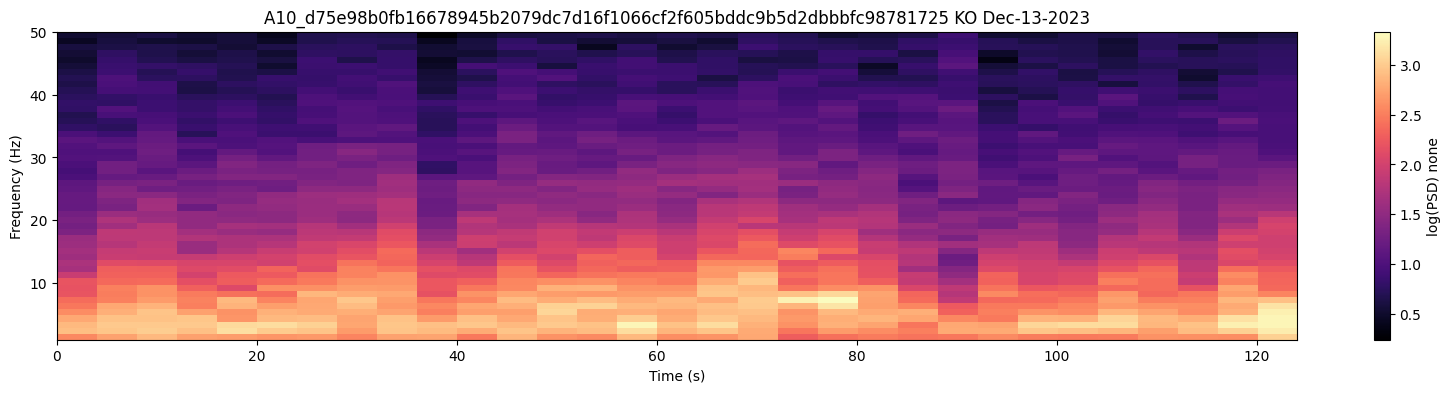

In [11]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [12]:
war = visualization.WindowAnalysisResult.load_pickle_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT FMUT(2)')
war.result.head(1)

Channel names: 	['LMot', 'RMot', 'LBar', 'RBar', 'LAud', 'RAud', 'LVis', 'RVis', 'LHip', 'RHip']
Channel abbreviations: 	['LMot', 'RMot', 'LBar', 'RBar', 'LAud', 'RAud', 'LVis', 'RVis', 'LHip', 'RHip']


,animalday,isday,animal,day,genotype,duration,endfile,timestamp,rms,ampvar,...,logampvar,logpsdtotal,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,zpcorr,psd
0,FMUT(2) FMut Jan-16-2022,False,FMUT(2),Jan-16-2022,FMut,18532.0,NaN,2022-01-16 18:00:03.930,"[133.2267539270864, 76.76584001111517, 107.123...","[18190.551418321043, 5976.1866000535565, 11675...",...,"[9.753924197378732, 8.66438316494648, 9.327918...","[9.541859430262399, 8.414976705759486, 9.17629...","{'delta': [11316.08074869245, 2961.16704382761...","{'delta': [0.7202806914891007, 0.6096927649920...","{'delta': [9.198971210728567, 7.89950195660448...","{'delta': [0.5403296873025356, 0.4735025631959...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."


In [13]:
# war = visualization.WindowAnalysisResult.load_pickle_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/071321_Cohort 3_AM4_CF1_DF3_FF6 DF3')
# war = visualization.WindowAnalysisResult.load_pickle_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/071321_Cohort 3_AM4_CF1_DF3_FF6 AM4')
# war = visualization.WindowAnalysisResult.load_pickle_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 CM5')
# war = visualization.WindowAnalysisResult.load_pickle_and_json('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT OLDMMT')
# war.result.head(1)

# pd.read_pickle('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT FMUT(2)/fmut2-fmut.pkl').head(1)

pd.read_pickle('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars-sox5-collapsed-6-isday/011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT OLDMMT/oldmmt-mmut.pkl').head(1)

,animalday,isday,animal,day,genotype,duration,endfile,timestamp,rms,ampvar,...,logampvar,logpsdtotal,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,zpcorr,psd
0,OLDMMT MMut Jan-16-2022,False,OLDMMT,Jan-16-2022,MMut,18532.0,NaN,2022-01-16 18:00:03.830,"[127.56671991697966, 125.30231883188691, 123.1...","[27086.478103135076, 26871.651890147816, 25659...",...,"[9.149252434855592, 9.03848810268171, 9.008234...","[7.090677338551791, 6.480647277704459, 6.57134...","{'delta': [5742.948189658981, 5081.40892532895...","{'delta': [0.7000473946053839, 0.6980131984369...","{'delta': [6.672226756680886, 6.08237625555724...","{'delta': [0.5226208755294606, 0.5238662776621...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."


In [14]:
logger.setLevel(logging.DEBUG)
wars = []
# animal_ids = ['A5', 'A10', 'F22']
animal_ids = [p for p in Path("./test-wars-sox5-collapsed-6-isday").glob("*") if p.is_dir()]
# bad_animal_ids = []
bad_animal_ids = [
    "013122_cohort4_group7_2mice both_FHET FHET(2)",
    "012322_cohort4_group6_3mice_FMUT___MMUT_MWT MHET",
    "012322_cohort4_group6_3mice_FMUT___MMUT_MWT MMUT",
    "011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT OLDMMT",
    "011322_cohort4_group3_4mice_AllM_MT_WT_HET_WT M3",
    "012322_cohort4_group6_3mice_FMUT___MMUT_MWT FHET"
    # "060921_Cohort 3_EM1_AM2_GF4 AM2" # this seems fine just very high delta for whatever reason
]
animal_ids = [p for p in animal_ids if p.name not in bad_animal_ids]
print([p.name for p in animal_ids])

for i, animal_id in enumerate(animal_ids):
    war = visualization.WindowAnalysisResult.load_pickle_and_json(animal_id)
    war.add_unique_hash(4)
    wars.append(war)

ep = visualization.ExperimentPlotter(
    wars=wars,
    exclude=["nspike", "lognspike"],
    # exclude=["nspike", "lognspike", "zpcorr"],
    # exclude=["nspike", "psdfrac", "logrms", "logampvar", "logpsdtotal", "lognspike", "logpsdband", "logpsdfrac"],
)


['071321_Cohort 3_AM4_CF1_DF3_FF6 DF3', '031722_cohort_6_group1_3mice_MMUT_MMUT_MWT M7', '012022_cohort4_group5_3mice__FWT_MMUT_FMUT FWT', '031021_cohort 2, group 3 and 4 #8 Cage 1A', '031921_cohort 2 group 5 and group 6 mouse M5 cage2A', '062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 BF3', '031621_cohort 2 group 2 and group 5 F10', '062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 AM3', '031021_cohort 2, group 3 and 4 #2 Cage 2A', '010822_cohort4_group2_2mice_MWT_MHET M10', '011322_cohort4_group3_4mice_AllM_MT_WT_HET_WT M2', '031722_cohort_6_group1_3mice_MMUT_MMUT_MWT MMUT(2)', ' 032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-Recording', '062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 CM9', '062122_group 10_2mice_F7Het_F9Mut F9', '062921_Cohort 3_AM3_AM5_CM9_BM6_CM5_CF2_IF5_BF3 CM5', '031621_cohort 2 group 2 and group 5 M2', '061322_Group10 M8, M10 M10', '081922_cohort10_group4_2mice_FMut_FHet FMUT', '011622_cohort4_group4_3mice_MMutOLD_FMUT_FMUT_FWT FMUT_', '061022_group 9 M1, M2, M3

2025-07-08 20:38:03,344 - DEBUG - LAud is already an abbreviation
2025-07-08 20:38:03,346 - DEBUG - RAud is already an abbreviation
2025-07-08 20:38:03,351 - DEBUG - LVis is already an abbreviation
2025-07-08 20:38:03,352 - DEBUG - RVis is already an abbreviation
2025-07-08 20:38:03,353 - DEBUG - LHip is already an abbreviation
2025-07-08 20:38:03,354 - DEBUG - RHip is already an abbreviation
Channel names: 	['LMot', 'RMot', 'LBar', 'RBar', 'LAud', 'RAud', 'LVis', 'RVis', 'LHip', 'RHip']
Channel abbreviations: 	['LMot', 'RMot', 'LBar', 'RBar', 'LAud', 'RAud', 'LVis', 'RVis', 'LHip', 'RHip']
2025-07-08 20:38:03,361 - DEBUG - LMot is already an abbreviation
2025-07-08 20:38:03,362 - DEBUG - RMot is already an abbreviation
2025-07-08 20:38:03,362 - DEBUG - LBar is already an abbreviation
2025-07-08 20:38:03,363 - DEBUG - RBar is already an abbreviation
2025-07-08 20:38:03,377 - DEBUG - LAud is already an abbreviation
2025-07-08 20:38:03,380 - DEBUG - RAud is already an abbreviation
2025-0

In [18]:
def process_feature_dataframe(df, feature):
        """Process feature dataframe by adding categorical columns and pivoting.

        Args:
            df (pd.DataFrame): Input dataframe with feature data
            feature (str): Name of feature being processed

        Returns:
            tuple: (processed_df, pivoted_df)
        """
        if feature in ["logpsdfrac", "logpsdband", "psdband", "cohere"]:
            groupby = ["animal", "isday", "band"]
            band_order = ["delta", "theta", "alpha", "beta", "gamma"]
            df["band"] = pd.Categorical(df["band"], categories=band_order, ordered=True)
        elif feature in ["pcorr", "zpcorr", "psd", "normpsd"]:
            groupby = ["animal", "isday"]
        else:
            raise ValueError(f"Feature {feature} not supported")
        if "isday" not in df.columns:
            groupby.remove("isday")

        genotype_order = ["FWT", "FHet", "FMut", "MWT", "MHet", "MMut"]
        gene_order = ["WT", "Het", "Mut"]

        df["genotype"] = pd.Categorical(df["genotype"], categories=genotype_order, ordered=True)
        df["sex"] = df["genotype"].map(
            lambda x: "Male" if x in ["MWT", "MHet", "MMut"] else "Female" if x in ["FWT", "FHet", "FMut"] else None
        )
        df["gene"] = df["genotype"].map(
            lambda x: "WT"
            if x in ["MWT", "FWT"]
            else "Het"
            if x in ["MHet", "FHet"]
            else "Mut"
            if x in ["MMut", "FMut"]
            else x
        )
        df["gene"] = pd.Categorical(df["gene"], categories=gene_order, ordered=True)
        if "isday" in df.columns:
            df["isday"] = df["isday"].map(lambda x: "Day" if x else "Night")

        if "band" in df.columns:
            df = df.sort_values(["band", "gene", "sex"])
        else:
            df = df.sort_values(["gene", "sex"])

        df_pivot = df.pivot_table(
            index=["animal", "gene", "sex"] if "freq" not in df.columns else ["animal", "gene", "sex", "freq"],
            columns=["isday", "band"] if ("isday" in df.columns and "band" in df.columns) else "band" if "band" in df.columns else "isday" if "isday" in df.columns else None,
            values=feature,
            aggfunc="mean",
            observed=True,
        ).reset_index()

        if isinstance(df_pivot.columns, pd.MultiIndex):
            df_pivot.columns = [
                "-".join(str(x) for x in col if x != "") if isinstance(col, tuple) else col for col in df_pivot.columns
            ]
        df_pivot.columns.name = None
        if "band" in df_pivot.columns:
            df_pivot = df_pivot.sort_values(["band", "gene", "sex"])
        else:
            df_pivot = df_pivot.sort_values(["gene", "sex"])

        return df, df_pivot

In [19]:
save_folder = '/home/dongjp/Downloads/7-7 ep'
save_files = False
save_folder = Path(save_folder)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
display(save_folder)

PosixPath('/home/dongjp/Downloads/7-7 ep')

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:235: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, tril_indices[0], tril_indices[1]], axis=-1)


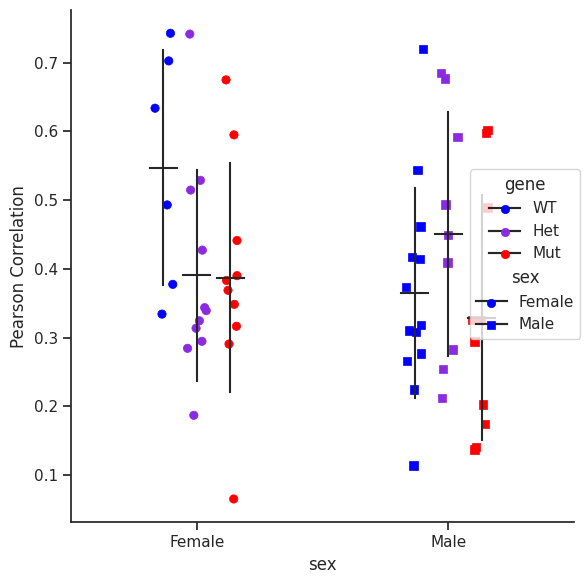

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:235: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals[:, tril_indices[0], tril_indices[1]], axis=-1)


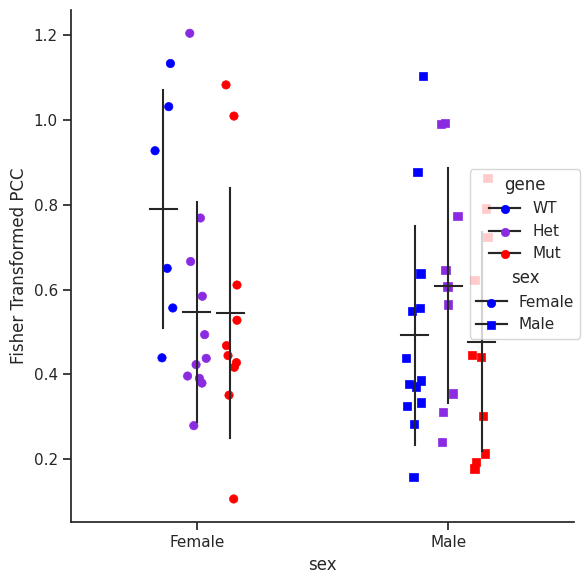

In [22]:
logger.setLevel(logging.INFO)

# features = ['psdtotal', 'psdslope', 'logpsdtotal']
# features = ["pcorr", "cohere", "logpsdfrac", "logpsdband"]
features = ["pcorr", "zpcorr"]
# features = ["zpcorr"]
# features = ["pcorr", "zpcorr", "cohere", "logpsdfrac", "logpsdband", "psdband", "psd", "normpsd"]
feature_to_label = {
    "pcorr": "Pearson Correlation",
    "zpcorr": "Fisher Transformed PCC",
    "cohere": "Coherence",
    "logpsdfrac": "Log Percent Power",
    "logpsdband": "Log Band Power",
    "psdband": "Band Power ($\mu V^2$)",
    "psd": "PSD ($\mu V^2/Hz$)",
    "normpsd": "Normalized PSD",
}
# features = ["psdfrac"]
# features = ["psd", "normpsd"]
for feature in features:
    # df = ep.pull_timeseries_dataframe(feature=feature, groupby=["animal", "genotype", "isday"], collapse_channels=True)
    if feature == "normpsd":
        df = ep.pull_timeseries_dataframe(feature="psd", groupby=["animal", "genotype"], collapse_channels=True)
        df_total = ep.pull_timeseries_dataframe(feature="psdtotal", groupby=["animal", "genotype"], collapse_channels=True)
        
        df = df.merge(df_total, on=["animal", "genotype", "channel"], suffixes=("", "_total"))
        df["normpsd"] = df["psd"] / df["psdtotal"]
    else:
        df = ep.pull_timeseries_dataframe(feature=feature, groupby=["animal", "genotype"], collapse_channels=True)

    df, df_pivot = process_feature_dataframe(df, feature)

    if save_files:
        df.to_csv(save_folder / f"{feature}.csv")
        df_pivot.to_csv(save_folder / f"{feature}-pivot.csv")

    if feature in ["pcorr", "zpcorr"]:
        p = (
            so.Plot(df, x="sex", y=feature, color="gene", marker="sex")
            # .facet(col="isday")
            .add(so.Dash(color="k"), so.Agg(), so.Dodge(empty="drop", gap=0.2))
            .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge(empty="drop", gap=0.2))
            .add(so.Dot(), so.Dodge(empty="drop", gap=0.2), so.Jitter(0.75, seed=42))
            # .add(
            #     so.Text(valign="top", fontsize=10),
            #     so.Dodge(empty="drop", gap=0.2),
            #     so.Jitter(0.5, seed=42),
            #     text="animal",
            # )
            .scale(marker=so.Nominal(["o", "s"], order=["Female", "Male"]))
            .theme(
                axes_style("ticks")
                | sns.plotting_context("notebook")
                | {"axes.prop_cycle": plt.cycler(color=["blue", "blueviolet", "red"])}
                | {"axes.spines.right": False, "axes.spines.top": False}
            )
            .layout(size=(6, 6))
            .label(y=feature_to_label[feature])
        )
        if save_files:
            p.save(save_folder / f"{feature}.tif", bbox_inches="tight", dpi=300)
        else:
            p.show()
    elif feature in ["logpsdfrac", "logpsdband", "psdband", "cohere"]:
        p = (
            so.Plot(df, x="band", y=feature, color="gene", marker="sex")
            # .facet(col="isday")
            .add(so.Dash(color="k"), so.Agg(), so.Dodge())
            .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge())
            .add(so.Dot(), so.Dodge(), so.Jitter(0.75, seed=42))
            # .add(
            #     so.Text(valign="top", fontsize=10),
            #     so.Dodge(),
            #     so.Jitter(seed=42),
            #     text="animal",
            # )
            .scale(marker=so.Nominal(["o", "s"], order=["Female", "Male"]))
            .theme(
                axes_style("ticks")
                | sns.plotting_context("notebook")
                | {"axes.prop_cycle": plt.cycler(color=["blue", "blueviolet", "red", "blue", "blueviolet", "red"])}
                | {"axes.spines.right": False, "axes.spines.top": False}
            )
            .label(x="Frequency band", y=feature_to_label[feature])
        )
        p1 = p.layout(size=(10, 6), engine="tight")
        # p2 = p.add(
        #     so.Text(valign="top", fontsize=10),
        #     so.Dodge(),
        #     so.Jitter(seed=42),
        #     text="animal",
        # ).layout(size=(20, 10), engine="tight")

        if save_files:
            p1.save(save_folder / f"byband-{feature}.tif", bbox_inches="tight", dpi=300)
            # p2.save(save_folder / f"byband-{feature}-text.png", bbox_inches="tight")
        else:
            p1.show()
            # p2.show()

        # with mpl.rc_context(plt.style.library["bmh"] | sns.plotting_context("notebook")):
        # with mpl.rc_context(sns.plotting_context("notebook")):
        p = (
            so.Plot(df, x="gene", y=feature, color="band", marker="sex")
            # .facet(col="isday")
            .add(so.Dash(color="k"), so.Agg(), so.Dodge())
            .add(so.Range(color="k"), so.Est(errorbar="sd"), so.Dodge())
            .add(so.Dot(), so.Dodge(), so.Jitter(0.75, seed=42))
            # .theme(plt.style.library['bmh'])
            .theme(
                axes_style("ticks")
                | sns.plotting_context("notebook")
                | {"axes.prop_cycle": plt.cycler(color=[blue, orange, red, green, purple, yellow, lightblue, black])}
                | {"axes.spines.right": False, "axes.spines.top": False}
            )
            .layout(size=(10, 6), engine="tight")
            .label(x="Genotype", y=feature_to_label[feature])
        )
        # p = p.add(so.Text(valign="top", fontsize=10), so.Dodge(), so.Jitter(seed=42), text="animal")
        if save_files:
            p.save(save_folder / f"bygeno-{feature}.tif", bbox_inches="tight", dpi=300)
        else:
            p.show()
    elif feature == "psd" or feature == "normpsd":
        ylim = (1e-4, 1) if feature == "normpsd" else (0.3, 3000)
        p = (
            so.Plot(df, x="freq", y=feature, color="gene")
            # .facet(col="sex", row="isday")
            .facet(col="sex")
            # .add(so.Line(), so.Agg(), so.Norm())
            .add(so.Line(), so.Agg()) # TODO norm manually in the dataframe and also plot bands. Norm by max value for each dataframe? or by max value for average genotype?
            .add(so.Band(), so.Est())
            .scale(x='log', y='log')
            .theme(
                axes_style("ticks")
                | sns.plotting_context("notebook")
                | {"axes.prop_cycle": plt.cycler(color=["blue", "blueviolet", "red"])}
                | {"axes.spines.right": False, "axes.spines.top": False}
            )
            .limit(x=(1, 100), y=ylim)
            .layout(size=(10, 6))
            .label(x="Frequency (Hz)", y=feature_to_label[feature])
        )

        if save_files:
            p.save(save_folder / f"{feature}.tif", bbox_inches="tight", dpi=300)
        else:
            p.show()

In [24]:
# df = ep.pull_timeseries_dataframe(feature="psd", groupby=["animal", "genotype", "isday"], collapse_channels=True)

# df, df_pivot = process_feature_dataframe(df, "psd")


In [25]:
# import statsmodels.api as sm
# from statsmodels.stats.anova import AnovaRM

# anova = AnovaRM(df, depvar='psd', subject='animal',
#                 within=['isday'], between=['sex'])
# result = anova.fit()

# display(result)


In [26]:
# for feat in constants.LINEAR_FEATURE + ['psdband']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, 'animal')
#     # display(df)
#     # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
#     ep.plot_catplot(feat, 'animal', kind='violin')

# ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
#                 x='animal',
#                 col='isday',
#                 hue='band',
#                 kind='boxen',
#                 collapse_channels=False,
#                 catplot_params={'showfliers': False})

In [27]:
# for feat in ['cohere']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
#     ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/utils.py:370: RuntimeWarning: Mean of empty slice
  xmean: np.ndarray = np.nanmean(np.array(list(x)), axis=axis)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:537: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:537: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:537: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:537: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:537: RuntimeWarning: Mean of empty slice
  avg_matrix = n

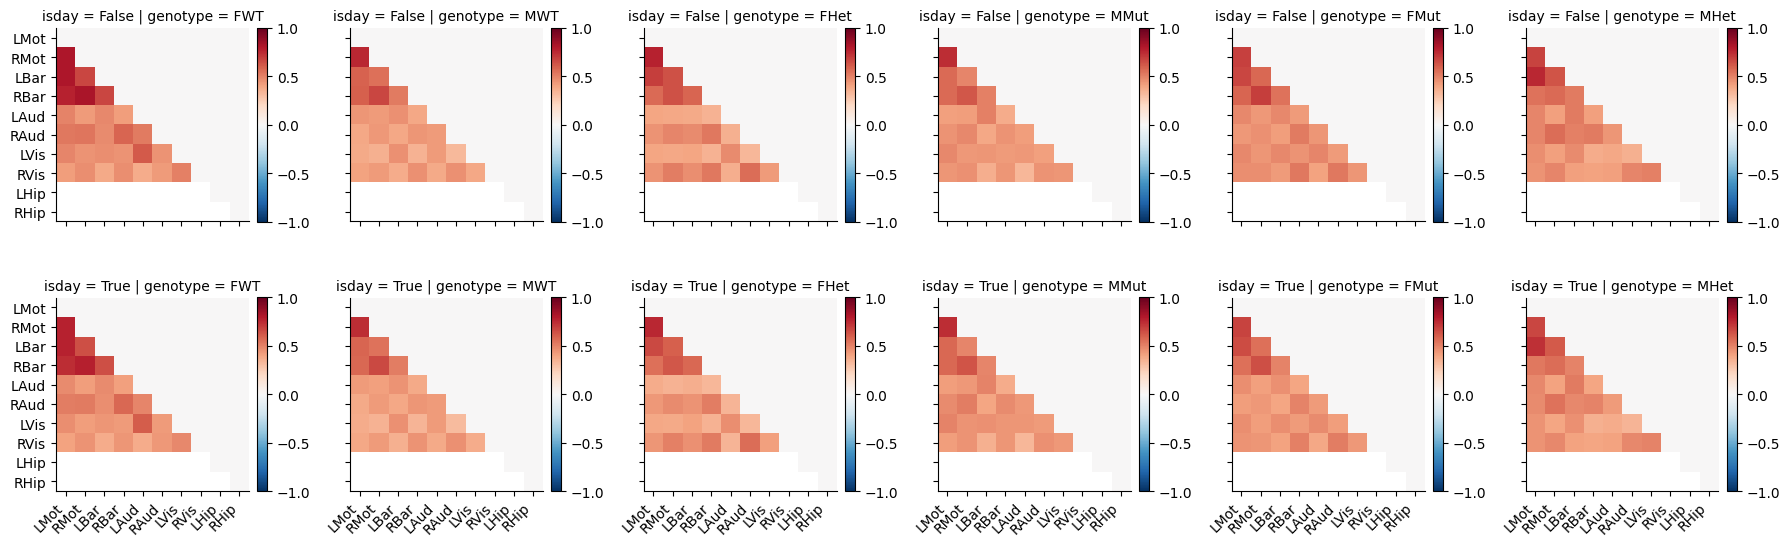

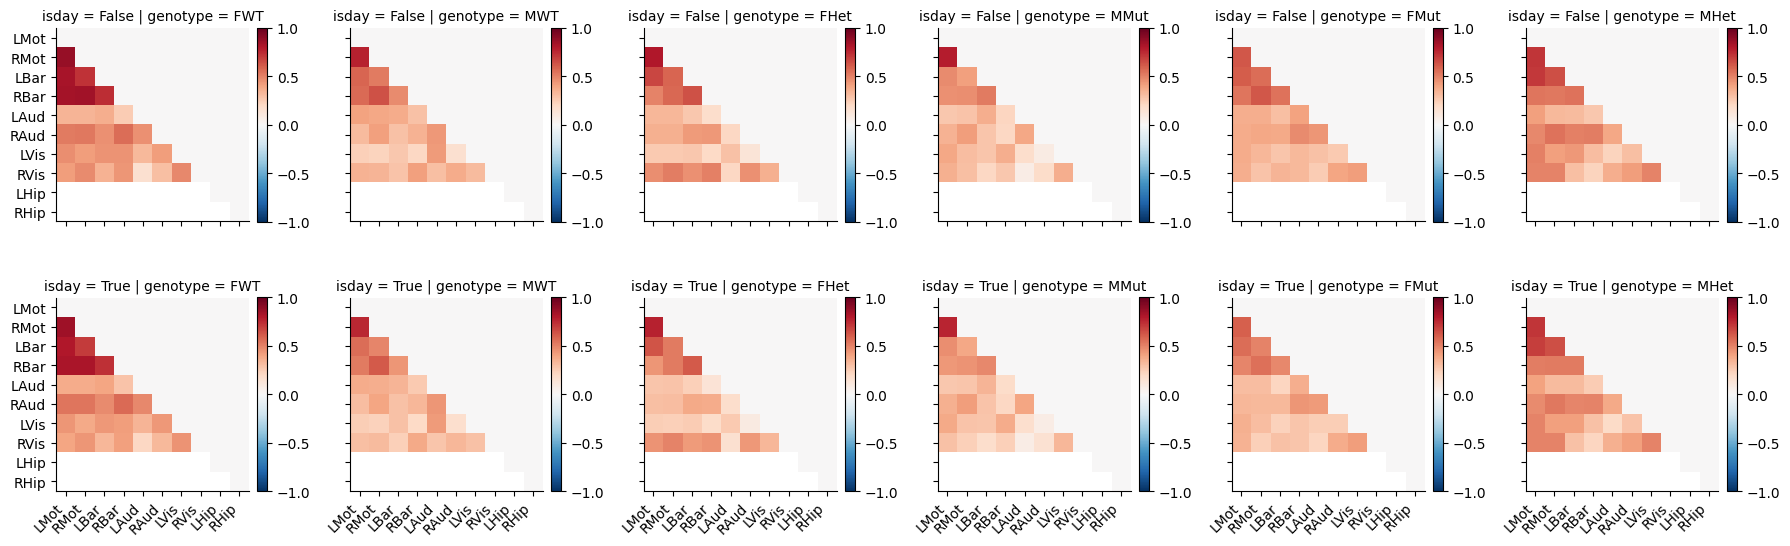

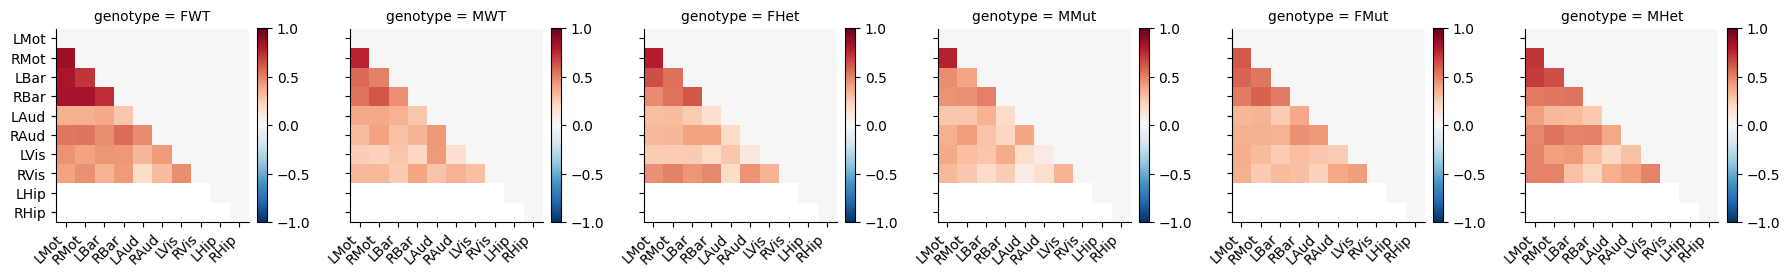

In [28]:
logger.setLevel(logging.INFO)
# df = ep.pull_timeseries_dataframe('cohere', ['genotype', 'isday'])
# df = ep.pull_timeseries_dataframe('pcorr', ['genotype'], average_groupby=False)
df = ep.pull_timeseries_dataframe('pcorr', ['genotype', 'isday'])


# ep.plot_heatmap('cohere', groupby=['animalday', 'genotype'])
ep.plot_heatmap('cohere', groupby=['genotype', 'isday'])


# ep.plot_heatmap('cohere', groupby='animalday', col='band', row='animalday')

ep.plot_heatmap('pcorr', groupby=['genotype', 'isday'])
ep.plot_heatmap('pcorr', groupby='genotype')

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:175: UserWarning: Groupby columns contain NaN values: isday (205/205 NaN values). This may result from previous aggregation operations (e.g., aggregate_time_windows) where these columns were not included in the groupby. Consider: 1) Including these columns in your aggregation groupby, or 2) Using different groupby columns.
  warnings.warn(warning_msg)


ValueError: Number of columns must be a positive integer, not 0

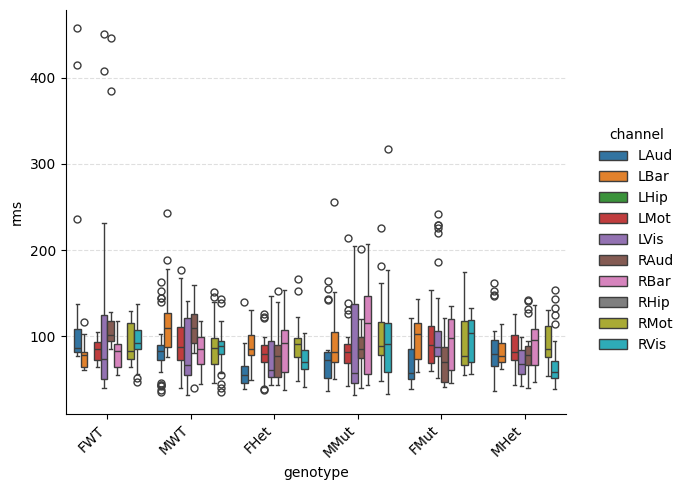

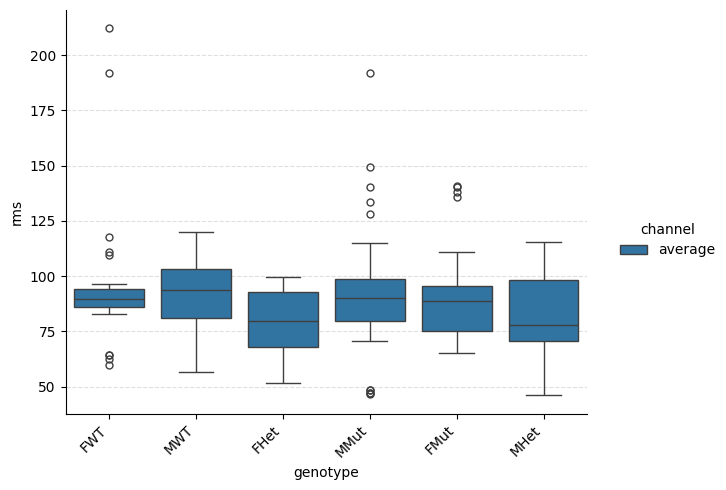

<Figure size 0x500 with 0 Axes>

In [ ]:
for feature in constants.LINEAR_FEATURES:
    if feature in ['nspike', 'psdfrac', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac']:
        print(f"Skipping feature {feature}")
        continue
    for kind in ['box', 'violin']:
        for groupby in ['genotype', ['genotype', 'isday']]:
            for collapse in [False, True]:
                ep.plot_catplot(feature, groupby=groupby, kind=kind, collapse_channels=collapse)
for kind in ['box', 'violin']:
    ep.plot_catplot('psdband', groupby=['genotype', 'isday'], 
                    x='genotype',
                    col='isday',
                    hue='band',
                    kind=kind, collapse_channels=True)
    ep.plot_catplot('psdband', groupby=['genotype'], 
                    x='genotype',
                    hue='band',
                    kind=kind, collapse_channels=True)

2025-06-11 22:19:40,419 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:40,420 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:40,422 - DEBUG - vals.shape: (1, 10)
2025-06-11 22:19:40,424 - DEBUG - vals.shape: (1, 10)


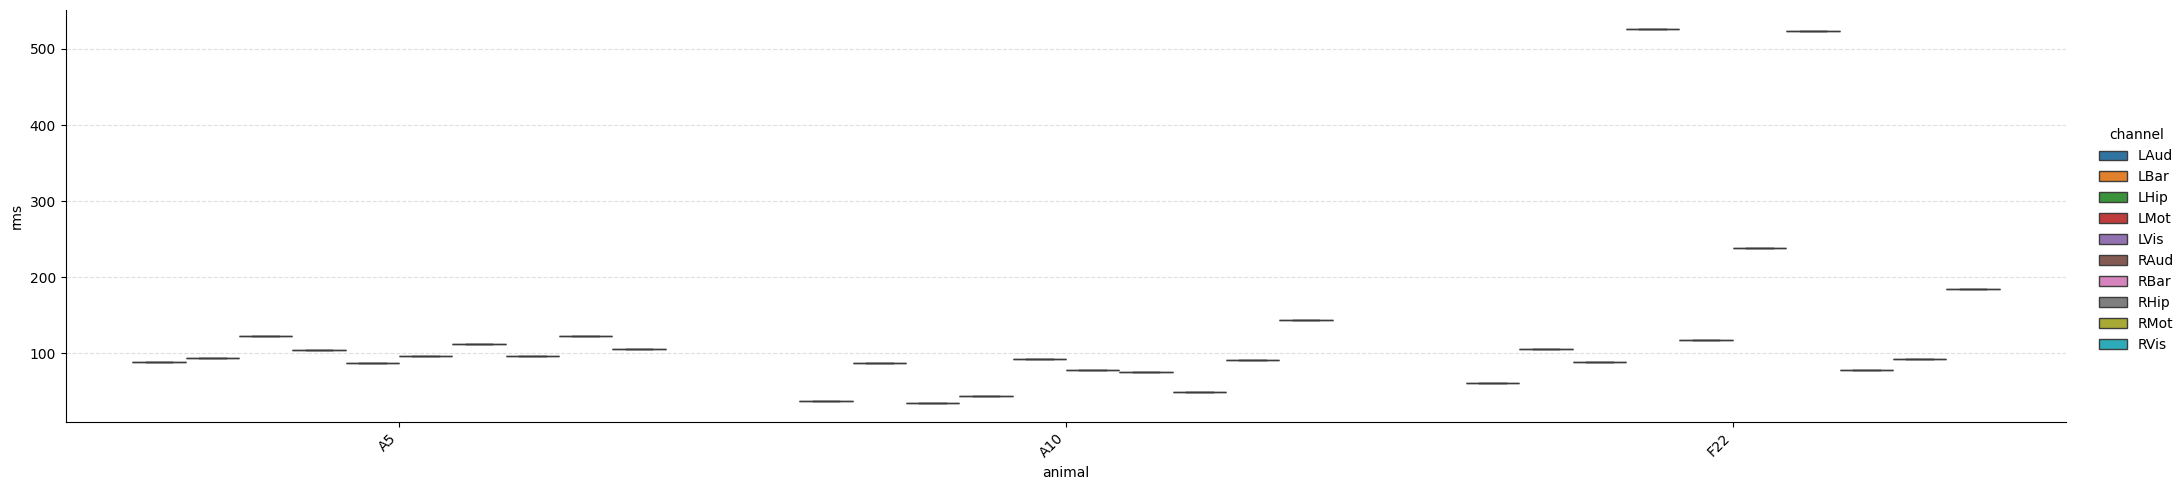

In [ ]:
ep.plot_catplot('rms', groupby='animal', kind='box', catplot_params={'showfliers': False, 'aspect': 4})

2025-06-11 22:19:41,010 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:41,011 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,013 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,014 - DEBUG - vals.shape: (1, 10, 10)
2025-06-11 22:19:41,174 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdfaaf6d0>
2025-06-11 22:19:41,196 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdfaf3280>
2025-06-11 22:19:41,219 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6cdf970a90>
2025-06-11 22:19:41,458 - DEBUG - groups: ['A10', 'A5', 'F22']
2025-06-11 22:19:41,459 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,460 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,461 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,462 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,463 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:41,464 - DEBUG - vals.shape: (1, 5, 10, 10)
2025-06-11 22:19:42,198 - DEBUG - 

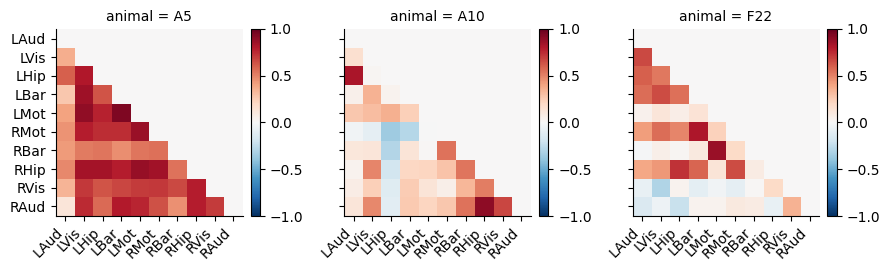

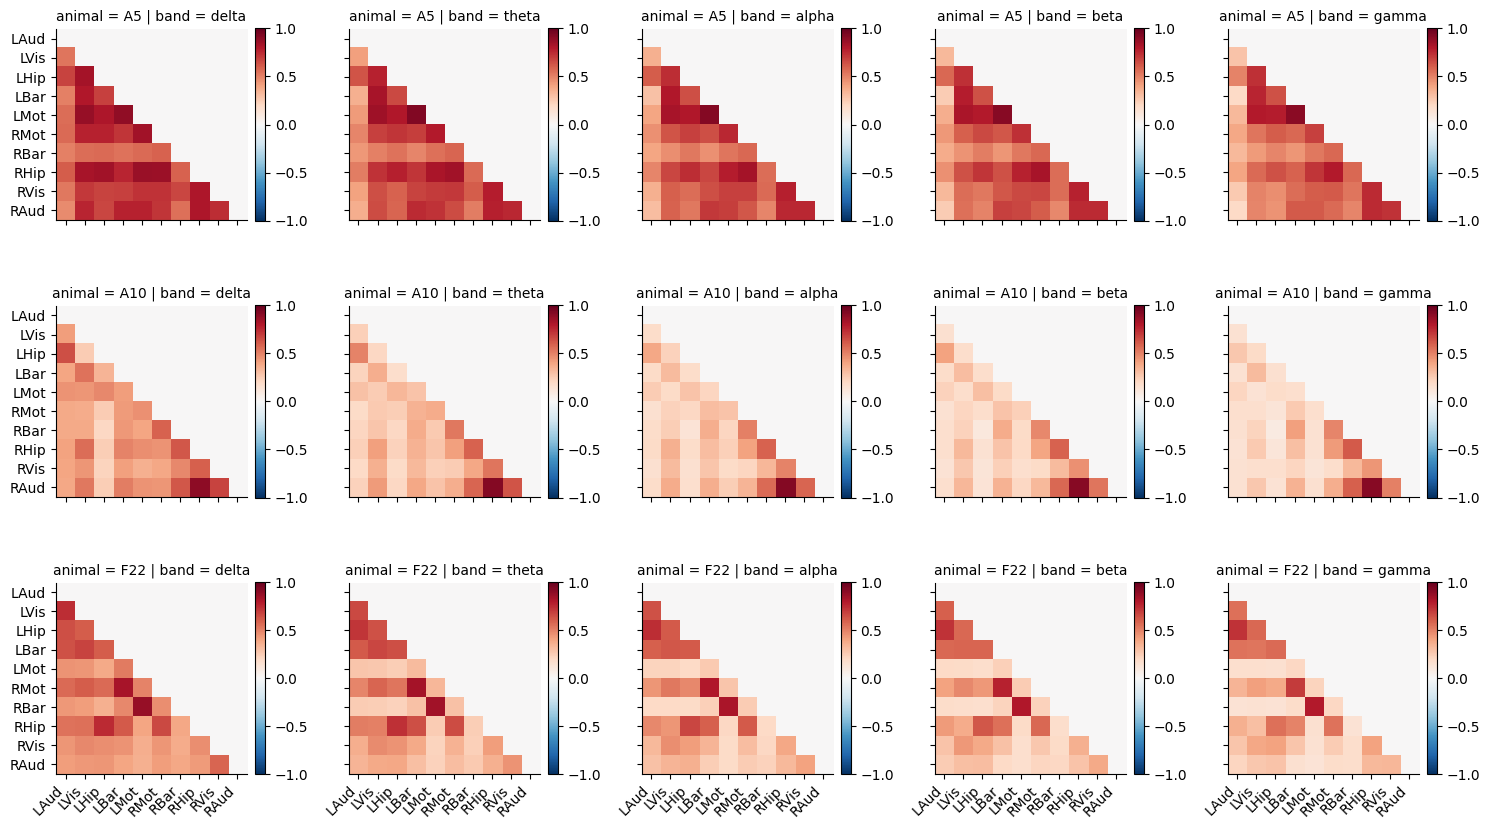

In [ ]:
ep.plot_heatmap('pcorr', groupby='animal')
ep.plot_heatmap('cohere', groupby='animal', col='band', row='animal')

In [ ]:
logger.setLevel(logging.DEBUG)

In [ ]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [ ]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


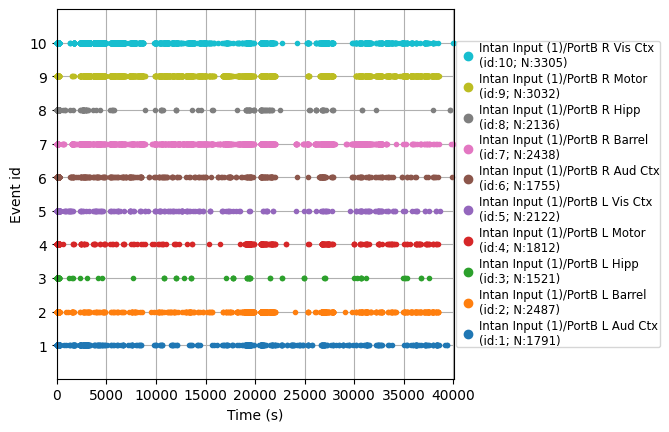

In [ ]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

In [ ]:
# Pivot the DataFrame to create Day and Night columns
df_pivoted = df.pivot_table(
    index=['animal', 'band'],  # These columns will identify unique rows
    columns='isday',           # The Day/Night values will become columns
    values='values',           # The values will be spread into Day/Night columns
    aggfunc='first'           # Since we expect one value per Day/Night, use first
).reset_index()

# Rename columns for clarity (optional)
df_pivoted.columns.name = None  # Remove the columns name
display(df_pivoted)
